# Train A Smartcab to Drive
Christopher Phillippi

![png](README_files/sim.png)

This project forks [Udacity's Machine Learning Nanodegree Smartcab project](https://github.com/udacity/machine-learning/tree/master/projects/smartcab) with my solution, modifying/adding `smartcab/agent.py` and `smartcab/notebookhelpers.py` as well as this `README`.

### Overall summary of the final agent learning algorithm:
In order to build a reinforcement learning agent to solve this problem, I ended up implementing $Q$ learning from the transitions. In class, we covered $\epsilon$-greedy exploration, where we selected the optimal action based on $Q$ with some probability 1 - $\epsilon$ and randomly otherwise. This obviously puts more weight on the current optimal strategy, but I wanted to put more or less weight on more or less suboptimal strategies as well. I did this by sampling actions in a simualted annealing fashion, assigning actions softmax probabilities of being sampled using the current $Q$ value with a decaying temperature. Further, each $Q(s, a_i)$ value is updated based on it's own exponentially decaying learning rate: $\alpha(s, a_i)$. The current temperature, $T(s)$, is defined as the sum of the decaying $\alpha(s, a)$ over all actions such that:

$$T(s) = \frac{1}{n}\sum_{i=0}^{n}{\alpha(s', a_j')}$$
$$P(a_i|Q,s) = \frac{e^{Q(s, a_i) / T(s)}}{\sum_{i=0}^{n}{e^{Q(s, a_i) / T(s)}}}$$

Once the action for exploration, $a_i$, is sampled, the algorithm realizes a reward, $R(s, a_i)$, and new state, $s'$. I then update $Q$ using the action that maximizes Q for the new state. The update equations for $Q$ and $\alpha(s, a_i)$ are below:

$$Q_{t+1}(s, a_i) = (1 - \alpha_t(s, a_i))Q_t(s, a_i) + \alpha_t(s, a_i)[R(s, a_i) + 0.05 \max_{a'}{Q_t(s', a')}]$$
$$\alpha_t(s, a_i) = 0.5(\alpha(s, a_i) - 0.05) + 0.05$$

and initially:
    $$Q_{0}(s, a_i) = 0$$
    $$\alpha_{0}(s, a_i) = 1.0$$

Note that while $\alpha(s, a_i)$ is decaying at each update, it hits a minimum of 0.05 (thus it never quits learning fully). Also, I chose a very low $\gamma=0.05$ here to discount the next maximum $Q$.

In terms of my state space, I use the following:
 - waypoint: {left, right, forward}
 - light: {green, red}
 - oncoming: {None, left, right, forward}
 - left: {True, False}
 - right: {True, False}

### Before implementing Q-Learning, did the smartcab eventually make it to the target location?

When randomly selecting actions, it's very literally acting out a random walk. It's worthing noting that on a 2D lattice, it's been proven that a random-walking agent will almost surely reach any point as the number of steps approaches infinity (McCrea Whipple, 1940). In other words, it will almost surely make it to the target location, especially because this 2D grid also has a finite number of points.

### Justification behind the state space, and how it models the agent and environment.

I picked the state space mentioned above based on features I believed mattered to the optimal solution. The waypoint effectively proxies the shortest path, and the light generally signals whether None is the right action. These two features alone should be sufficient to get a fairly good accuracy, though I did not test it. Further, I added traffic because this information can help optimize certain actions. For example, you can turn right on red conditional on no traffic from the left. You can turn left on green conditional on no oncoming traffic. 

I did not include the deadline here because we are incentivized to either follow the waypoint or stop to avoid something illegal. If we were learning our own waypoint based on the header, the deadline may be useful as a boolean feature once we’re close. Perhaps this would signal whether or not it would be efficient to take a right turn on red. Again, the deadline doesn’t help much given the game rewards.

I also compressed left/right which previously could be {None, left, right, forward} based on the other agents signals. Now they are True/False based on whether or not cars existed left/right. You could also likely compress the state space conditional on a red light, where only traffic on the left matters. I strayed from this approach as it involved too much hard coding for rules the Reinforcement Learner could learn with sufficient exploration.

There are only 96 unique states. Assuming each trial runs at least 5 steps, 100 trials views at least 500 states. Estimating the probability that each state will be seen here is tough since each state has a different probability of being picked based on the unknown true state distribution. Assuming the chance a state is picked is uniform, this becomes the Coupon Collector’s problem, where the expected number of trials, $T$,  until $k$ coupons are collected out of a total of $n$ is:

$$E[T_{n,k}] = n \sum_{i=n-k}^{n}\frac{1}{i}$$

We can see below that assuming states are drawn uniformly, we’d expect to see all of the states after about 500 runs, and about 90% after only 250 runs:

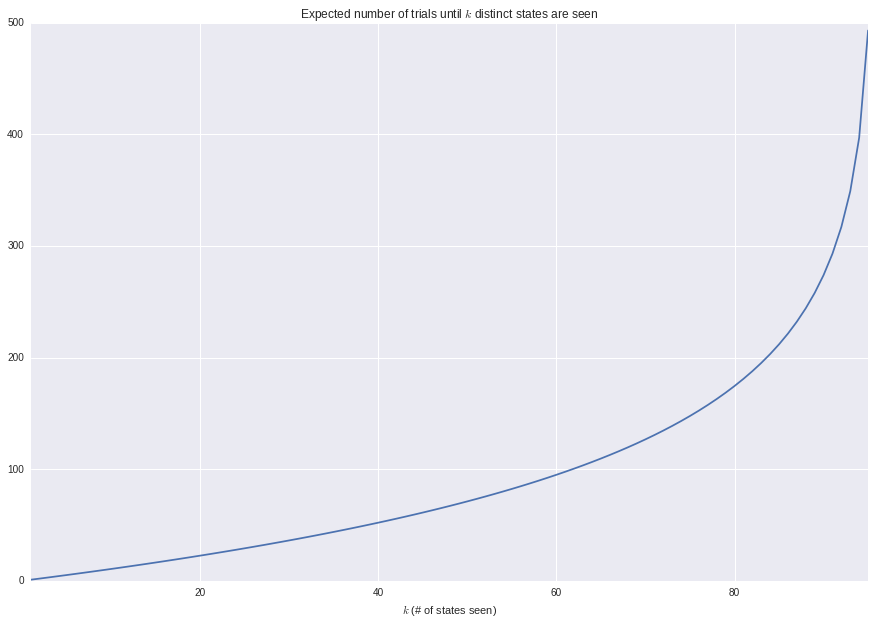

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
%matplotlib inline

def expected_trials(total_states):
    n_drawn = np.arange(1, total_states)
    return pd.Series(total_states * np.cumsum(1. / n_drawn[::-1]), n_drawn)

expected_trials(96).plot(title='Expected number of trials until $k$ distinct states are seen', figsize=(15, 10))
_ = pylab.xlabel('$k$ (# of states seen)')

Obviously, states are not drawn uniformly, but rather based on the simulated distribution with 20 dummy cars (I overrode the default of 3 to 20). Thus we’re more likely to have sampled the most likely states, and the missing states are less likely to be encountered later than if we had drawn states uniformly. In a production environment, I would make sure I run this until every possible state has been seen a sufficient number of times (potentially through stratification). For this project, I think seeing around 500 states is sufficient, and thus 100 trials should train a fairly reasonable agent.

### Changes in agent behavior after implementing Q-Learning

Initially after training the agent, it would consistently approach the destination, but would take very odd paths. For example, on a red light, it would commonly take a right turn, perhaps optimistic the next intersection would allow for a left turn on green, despite the penalty for disobeying the waypoint. I found this was due to my gamma being extremely high (0.95). Overall I was ultimately weighting the future rewards much more than the current penalties and rewards for taking each correct turn. The resulting agent somewhat ignored the waypoint and took it’s own optimal course, likely based on the fact that right turns on red just tend to be optimal. I think it’s reasonable that over time, the agent would have learned to follow the waypoint, assuming it’s the most efficient way to the destination, and perhaps the high gamma was causing slow convergence. It’s also possible the agent, weighting the final outcomes higher, found a more optimal waypoint to the end goal (ignoring illegal and waypoint penalties), but I think this is unlikely.

During training, the agent would occasionally pick a suboptimal action (based on Q). Usually this was akin to taking a legal right turn on red, when the waypoint wanted to wait and go forward. This was done to ensure the agent sufficiently explored the state space. If I simply picked the action corresponding to the maximum $Q$ value, the agent would likely get stuck in a local optima. Instead the randomness allows it to eventually converge to a global optima.

To visualize, the success rate while the initial $Q$-Learning model is shown below, followed by that same agent (now learned) using the optimal policy only:

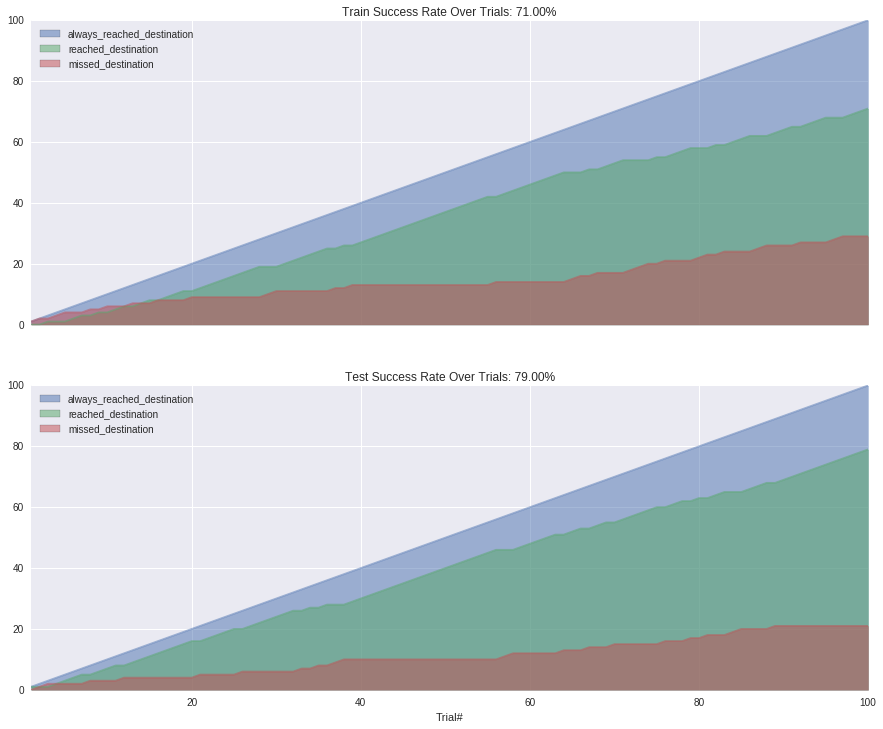

In [2]:
from smartcab.notebookhelpers import generated_sim_stats

def plot_cumulative_success_rate(stats, sim_type, ax=None):
    stats['always_reached_destination reached_destination missed_destination'.split()].cumsum().plot(
        ax=ax, kind='area', stacked=False, title='%s Success Rate Over Trials: %.2f%%' % (
            sim_type, stats.reached_destination.mean()*100
        )
    )
    pylab.xlabel('Trial#')

def train_test_plots(train_stats, test_stats, plot):
    _, (top, bottom) = pylab.subplots(2, sharex=True, sharey=True, figsize=(15, 12))
    plot(train_stats, 'Train', ax=top)
    plot(test_stats, 'Test', ax=bottom)

# Generate training, and test simulations
learned_agent_env, train_stats = generated_sim_stats(
    n_trials=100,
    gamma=0.95,
    alpha_span=100,
    min_alpha=0.05,
    initial_alpha=0.2,
)
_, test_stats = generated_sim_stats(agent_env=learned_agent_env, n_trials=100)

train_test_plots(train_stats, test_stats, plot_cumulative_success_rate)

What I noticed here was that the train performance was very similiar to the test performance in terms of the success rate. My intuition is that this is mainly due to the high gamma, which results in Q values that are slow to converge. Finally my $\alpha$ were decaying fairly slowly due to a span of 100, this caused my temperatures to stay high and randomly sample many suboptimal actions. Combined, this exacerbated bad estimates of Q values, which caused the test run to fail to significantly improve the overall success rate.

However, I did find that the test run was much safer after taking a look at the cumulative trips with crimes, thus it was learning:

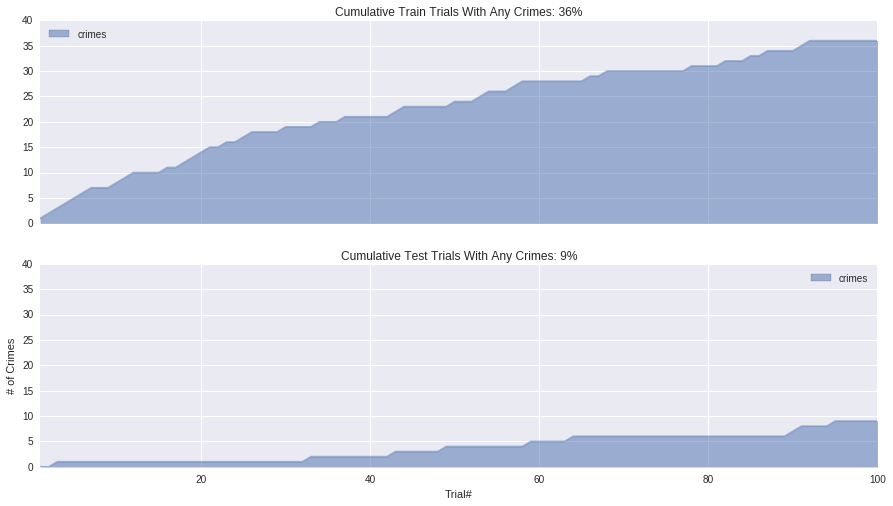

In [3]:
def plot_cumulative_crimes(stats, sim_type, ax=None):
    (stats['crimes'.split()] > 0).cumsum().plot(
        ax=ax, kind='area', stacked=False, figsize=(15, 8), title='Cumulative %s Trials With Any Crimes: %.0f%%' % (
            sim_type, (stats.crimes > 0).mean()*100
        )
    )
    pylab.ylabel('# of Crimes')
    pylab.xlabel('Trial#')


train_test_plots(train_stats, test_stats, plot_cumulative_crimes)

### Updates to the final agent and final performance

In [4]:
# Generate training, and test simulations
learned_agent_env, train_stats = generated_sim_stats(
    n_trials=100,
    gamma=0.05,
    initial_alpha=1.0,
    min_alpha=0.05,
    alpha_span=2.0,
)
_, test_stats = generated_sim_stats(agent_env=learned_agent_env, n_trials=100)

I made two major changes (as shown in the code above), based on my observations of the initial agent. First, I reduced the $\gamma$ all the way to 0.05 from 0.95. This caused my agent to pay much more attention to the current correct turn, and less on the final goal. This also means I can set a much larger initial $\alpha$ value since a majority of the new value is now deterministic (the reward).

Another key observation I made was that optimal moves were deterministic based on the state. In order to exploit this in the learner, I considered the following cases:

1. Reward of 12:
    - This is assigned when the car makes the correct move to the destination (not illegal or suboptimal).
2. Reward of 9.5:
    - This is assigned when the car makes an incorrect move to the destination (perhaps teleporting from one side to the other)
    - I map this to -0.5
3. Reward of 9:
    - This is assigned when the car makes an illegal move to the destination
    - I map this to -1
4. Reward of 2:
    - This is assigned when the car legally follows the waypoint
5. Reward of 0:
    - This is assigned when the car stops
6. Reward of -0.5:
    - This is assigned when the car makes a suboptimal but legal move (doesn't follow waypoint)
7. Reward of -1:
    - This is assigned when the car makes an illegal move
 

Now, any action with a positive reward is now an optimal action, and any action with a negative reward is suboptimal. Therefore, if I can get a positive reward, a good learner should not bother looking at any other actions, pruning the rest. If I encounter a negative, a good learner should never try that action again. The only uncertainty comes into play when the reward is 0 (stopping). In this case, we must try each action until we either find a positive rewarding action or rule them all out (as < 0). An optimal explorer then, will assign a zero probability to negative rewards, 1 probability to positive rewards, and a non-zero probability to 0 rewards. It follows that the initial value of Q should be 0 here. Naturally then, the explorer will do best as my temperature, $T$, for the softmax (action sampling) probabilities approaches 0. Since the temperature is modeled as the average $\alpha$, I greatly reduced the span of $\alpha$, from 200 to 2, promoting quick convergence for $\alpha \to 0.05$ and thus $T \to 0.05$. I then increased the initial value of $\alpha$ to 1.0 in order to learn $Q$ values much quicker (with higher magnitudes), knowing the $\alpha$ values themselves, will still decay to their minimum value of 0.05 quickly.
 
The final performance can be seen below:

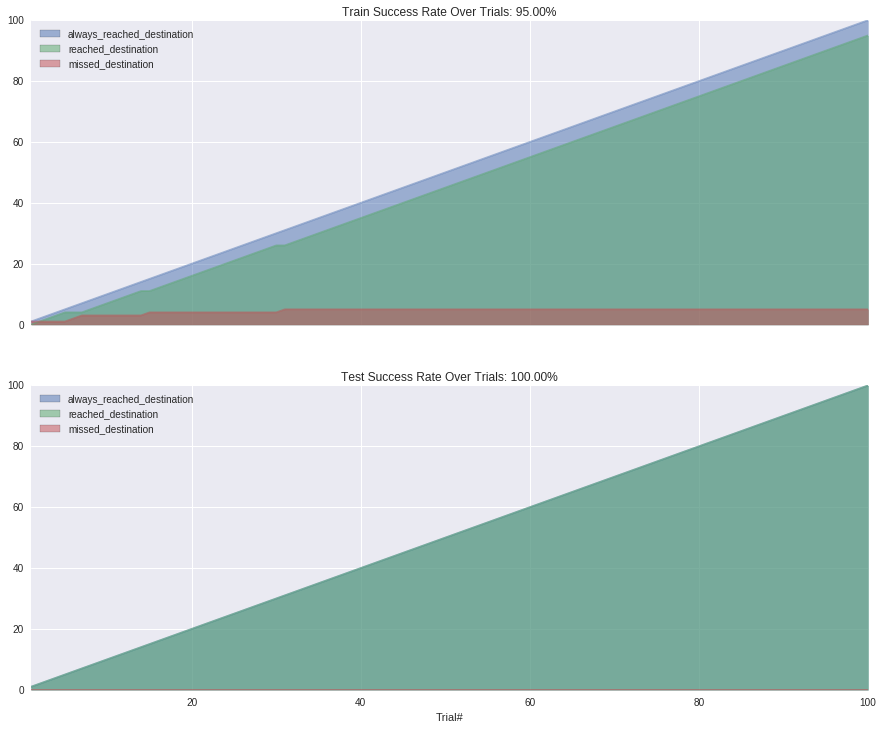

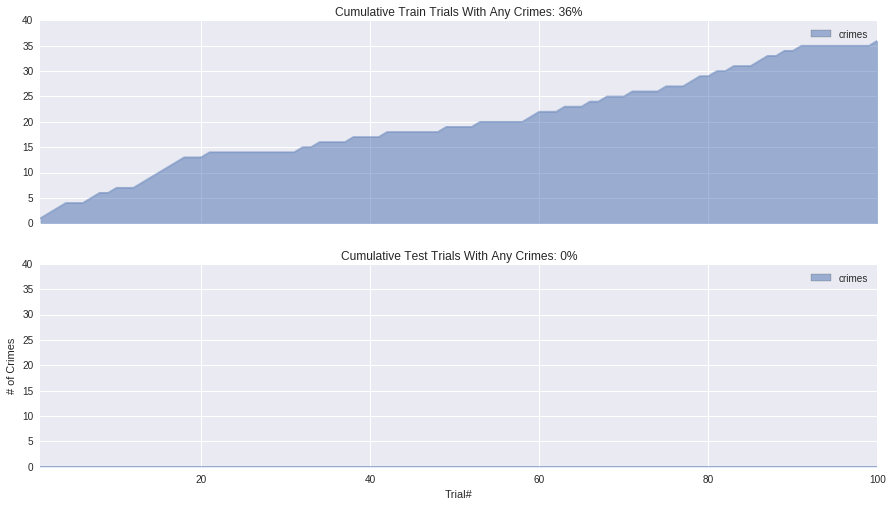

In [5]:
train_test_plots(train_stats, test_stats, plot_cumulative_success_rate)
train_test_plots(train_stats, test_stats, plot_cumulative_crimes)

### Optimality of the final policy

The agent effectively either took the waypoint or sat if it was illegal. That, to me, is optimal. Something I also looked into was learning my own waypoint by giving relative headings to the destination [up-left, up, up-right, left, right, down-left, down, down-right]. Obviously the environment is rewarding the wrong rewards for this scenario (tuned to the given waypoint), and I did not want to tamper with the environment so I wasn’t able to test this sufficiently. 

To get a formal measure of optimality, for each trial, I counted the number of steps, $t$, as well as the number of suboptimal steps (legal but not following waypoint) $t_s$ and crime (illegal) steps $t_c$. Optimality, $\theta$, on each trial is then 1 minus the ratio of non-optimal steps:

$$\theta = 1 - \frac{t_n + t_c}{t}$$

This is shown below for each trial:

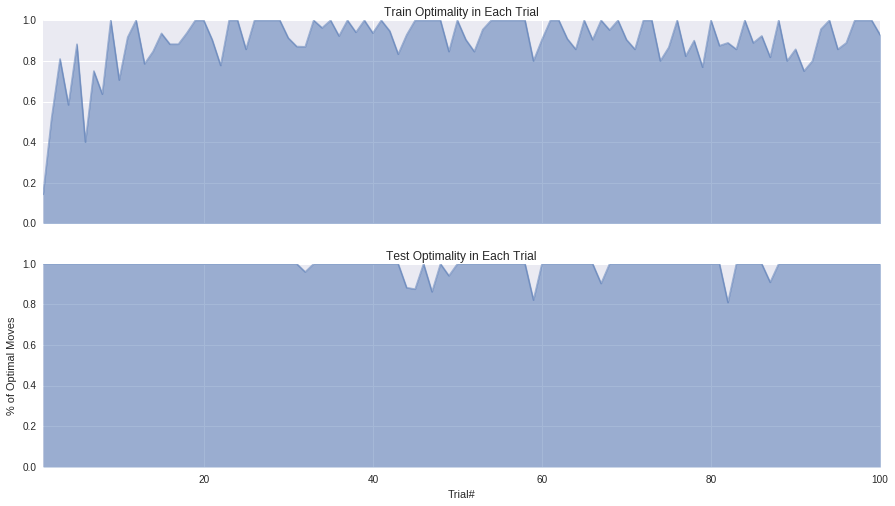

In [6]:
def plot_cumulative_optimality(stats, sim_type, ax=None):
    (1. - (stats['suboptimals'] + stats['crimes']) / stats['n_turns']).plot(
        ax=ax, kind='area', stacked=False, figsize=(15, 8), title='%s Optimality in Each Trial' % (
            sim_type
        )
    )
    pylab.ylabel('% of Optimal Moves')
    pylab.xlabel('Trial#')

train_test_plots(train_stats, test_stats, plot_cumulative_optimality)

Overall, the training model seems to learn the optimal path pretty quickly. Once exploration is turned off, the agent is near optimal.